In [ ]:
import pandas as pd

# Load edges dataset (assuming columns: 'source', 'target', 'weight')
edges_df = pd.read_csv('/content/sample_data/musae_RU_edges.csv')

# Load target dataset (assuming columns: 'id', 'views', 'partner', etc.)
target_df = pd.read_csv('/content/sample_data/musae_RU_target.csv')

# Display the first few rows of the datasets to confirm they are loaded correctly
print("Edges Dataset:")
print(edges_df.head())

print("Target Dataset:")
print(target_df.head())


Edges Dataset:
   from    to
0     0   646
1     0  2510
2     0  2425
3     0  2596
4     0    85
Target Dataset:
          id  days  mature  views  partner  new_id
0   43622128  1910   False   2002    False    1076
1   32314097  2273    True   1885    False    1090
2  112985248   998   False  14538    False     633
3   54595718  1738    True   8541    False    2238
4   72920173  1461   False  49854    False    1662


In [ ]:
import networkx as nx

# Create the graph object
G = nx.Graph()

# Add edges from edges_df to the graph
for _, row in edges_df.iterrows():
    source = row['from']
    target = row['to']
    weight = row.get('weight', 1)  # Default to weight 1 if not specified
    G.add_edge(source, target, weight=weight)

# Add nodes from target_df to ensure all nodes exist before adding attributes
for _, row in target_df.iterrows():
    influencer_id = row['id']
    # Add node if it doesn't exist:
    if influencer_id not in G:
        G.add_node(influencer_id)
    G.nodes[influencer_id].update(row.to_dict())

# Display the graph structure
print(f"Graph contains {len(G.nodes())} nodes and {len(G.edges())} edges.")

Graph contains 8770 nodes and 37304 edges.


In [ ]:
import numpy as np

def weighted_leader_rank_with_paths(G, alpha=0.85, max_iter=100, tol=1e-6):
    # Initialize the scores dictionary
    scores = {node: 1 / len(G.nodes()) for node in G.nodes()}

    # Perform iterative updates
    for _ in range(max_iter):
        new_scores = {}

        for node in G.nodes():
            # Get neighbors and edge weights for the current node
            neighbors = list(G.neighbors(node))
            if len(neighbors) == 0:
                new_scores[node] = 1 / len(G.nodes())  # No neighbors, keep initial score
                continue

            # Sum the weighted scores of the neighbors
            weighted_sum = 0
            total_weight = sum([G[node][neighbor].get('weight', 1) for neighbor in neighbors])  # Default weight = 1

            for neighbor in neighbors:
                edge_weight = G[node][neighbor].get('weight', 1)
                weighted_sum += (edge_weight / total_weight) * scores[neighbor]

            # Update the score using the formula
            new_scores[node] = (1 - alpha) / len(G.nodes()) + alpha * weighted_sum

        # Check for convergence (if the scores stop changing)
        max_diff = max(abs(new_scores[node] - scores[node]) for node in G.nodes())
        scores = new_scores
        if max_diff < tol:
            break

    return scores


In [ ]:
# Run the Weighted LeaderRank Algorithm (with paths)
influencer_scores = weighted_leader_rank_with_paths(G, alpha=0.85)

# Step 5: Sort and display the top influencers based on their scores
sorted_influencers = sorted(influencer_scores.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 influencers
top_10_influencers = sorted_influencers[:10]
for influencer, score in top_10_influencers:
    print(f'Influencer: {influencer}, LeaderRank Score: {score}')


Influencer: 646, LeaderRank Score: 0.00011402508551881549
Influencer: 907, LeaderRank Score: 0.00011402508551881491
Influencer: 2273, LeaderRank Score: 0.00011402508551881487
Influencer: 1916, LeaderRank Score: 0.00011402508551881487
Influencer: 208, LeaderRank Score: 0.00011402508551881486
Influencer: 912, LeaderRank Score: 0.0001140250855188148
Influencer: 3534, LeaderRank Score: 0.0001140250855188147
Influencer: 3348, LeaderRank Score: 0.0001140250855188147
Influencer: 3369, LeaderRank Score: 0.0001140250855188147
Influencer: 1829, LeaderRank Score: 0.00011402508551881469


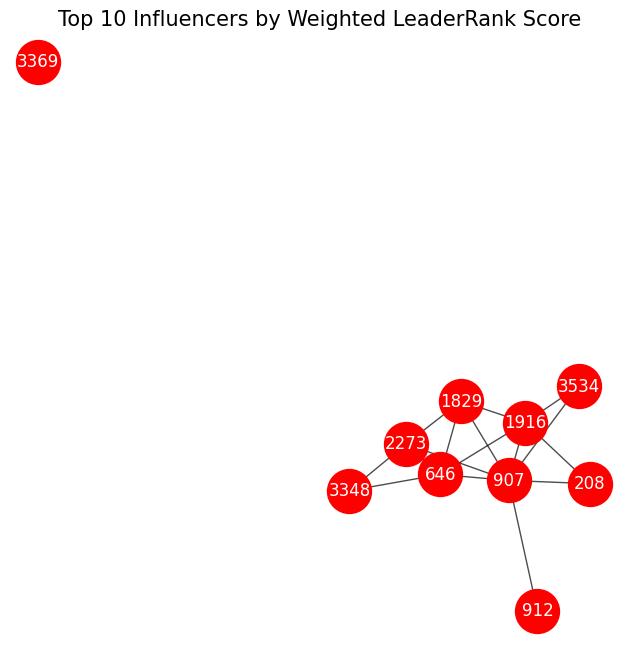

In [ ]:
# Get the top 10 nodes
top_10_nodes = [node for node, score in sorted_influencers[:10]]

# Create a subgraph with only the top 10 nodes
G_top_10 = G.subgraph(top_10_nodes)

# Plot the subgraph with top influencers
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_top_10, seed=42)
nx.draw_networkx_nodes(G_top_10, pos, node_size=1000, node_color='red')
nx.draw_networkx_edges(G_top_10, pos, alpha=0.7)
nx.draw_networkx_labels(G_top_10, pos, font_size=12, font_color='white')

plt.title("Top 10 Influencers by Weighted LeaderRank Score", fontsize=15)
plt.axis('off')
plt.show()
